# Time Series Regression

# Abstract

This project aimed to build a time series regression model to predict future horizons using a provided dataset. The process involved conducting exploratory data analysis, feature engineering, and preprocessing. Both linear and non-linear time series forecasting models were explored, including Prophet (which has shown superior performance compared to other simple autoregressive models like SARIMA, ARIMA, and ARMA) and Neural Prophet (based on a feed-forward neural network architecture capable of capturing non-linear trend characteristics). Two variants of each of the Prophet and Neural Prophet model were developed, including a pre-tuned model and a hyperparameter-tuned model. The models used feature engineered regressor variables such as time-based variables (Day, Month, Year, and Quarter) and the provided exogenous variables (A1 and B1). Extensive cross-validation was conducted using the Mean Absolute Error, and the performance of the models (Baseline Prophet, Tuned Prophet Model, Pre-tuned Neural Prophet, and Hyperparameter-tuned Neural Prophet) were compared. Results showed that the Hyperparameter-tuned Neural Prophet model achieved the best performance. Additionally, the choice of MAE as the cross validation metric and the impact of the variable output length model was discussed, highlighting its flexibility advantage but added complexity compared to fixed horizon forecasts.

Keywords: Time Series Forecasting, Linear Model, Non-Linear Model, Prophet, Neural Prophet, Deep Learning

## Methodology

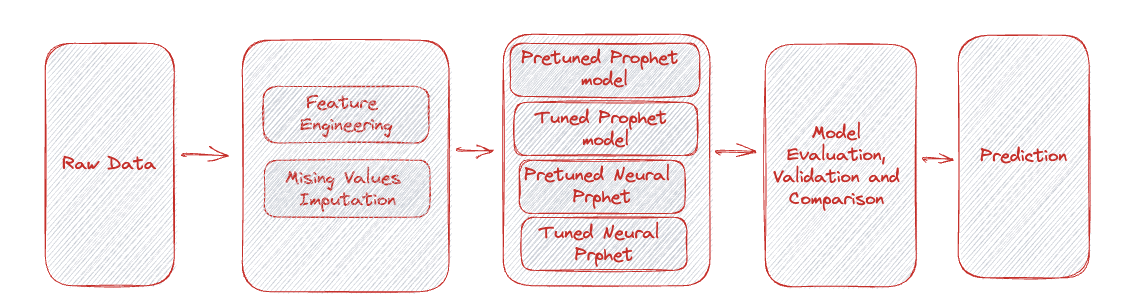

## Dev Environment and Import necessary packages

In [1]:
# cd neural_prophet 

In [2]:
from neuralprophet import NeuralProphet
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import set_matplotlib_formats
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid
from typing import List, Dict

# set_matplotlib_formats("retina")
# %load_ext nb_black

In [3]:
# cd /Users/oowola01/Library/Mobile Documents/com~apple~CloudDocs/OneDrive - Tufts/Apps/Job/Take Home/Kempstar/

## Load Data

In [4]:
#load data
df = pd.read_csv("data.csv")

## 1a. Exploratory Data Analysis 

In [5]:
df.head()

,date,target,A1,B1
0,8/17/18,24218,26639.85932,26712.400
1,8/24/18,24276,26732.24945,26670.446
2,8/31/18,24825,27234.12799,27424.310
3,9/7/18,23583,25763.61542,27435.742
4,9/14/18,22333,24621.30913,25207.102


In [6]:
# check the data types and missing values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    232 non-null    object 
 1   target  232 non-null    int64  
 2   A1      232 non-null    float64
 3   B1      232 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 7.4+ KB
None


In [7]:
# describe the data
print(df.describe())

             target            A1            B1
count    232.000000    232.000000    232.000000
mean   39554.314655  41311.507463  41802.437966
std    11333.888274  10374.618643  10975.584495
min    21261.000000  24621.309130  24330.309000
25%    28068.250000  31406.449942  30528.103000
50%    40145.000000  41227.770245  41998.529000
75%    47755.750000  48341.974315  49667.993750
max    65446.000000  63508.626030  66857.030000


In [8]:
# convert the date column to datetime format
df["date"] = pd.to_datetime(df["date"])

# set the date column as the index
df = df.set_index("date")

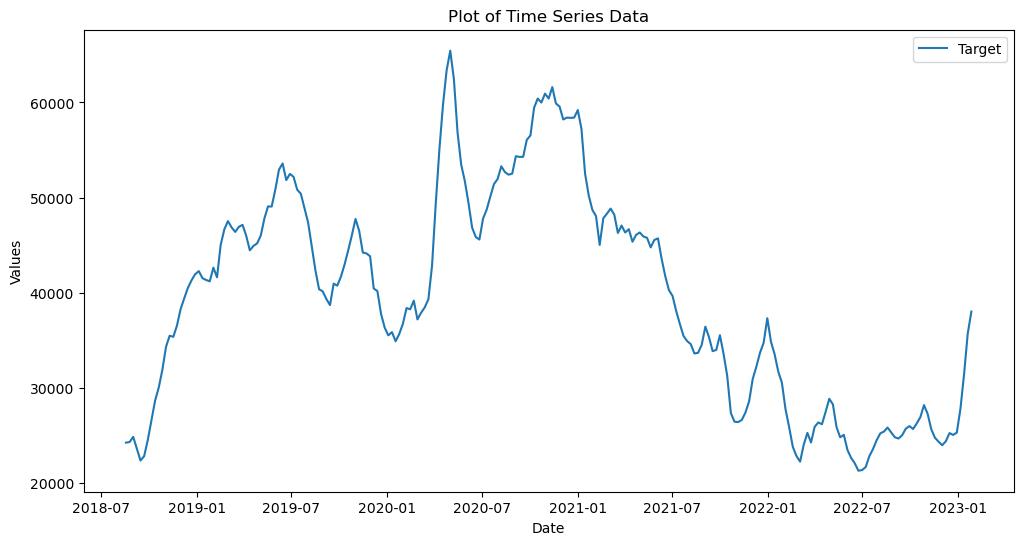

In [9]:
# plot the time series data
plt.figure(figsize=(12,6))
plt.plot(df[["target"]])
plt.title('Plot of Time Series Data')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend(["Target"])
plt.show()


WARNING - (py.warnings._showwarnmsg) - /var/folders/7_/w5fc08mx4f1f0vbfhy39l_1c0000gn/T/ipykernel_16695/800462424.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["target"])



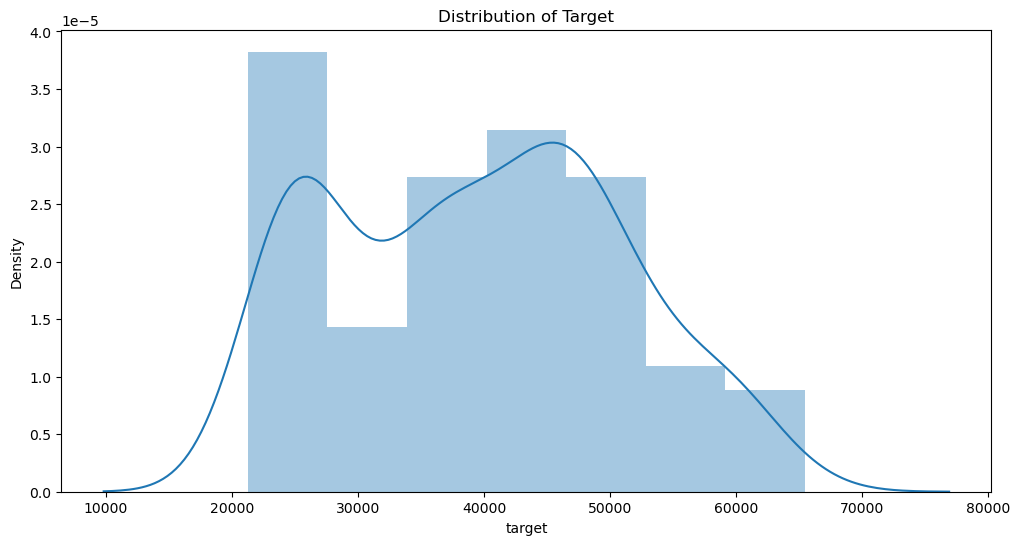

In [10]:
# plot the distribution of the data
plt.figure(figsize=(12, 6))
sns.distplot(df["target"])
plt.title("Distribution of Target")
plt.show()

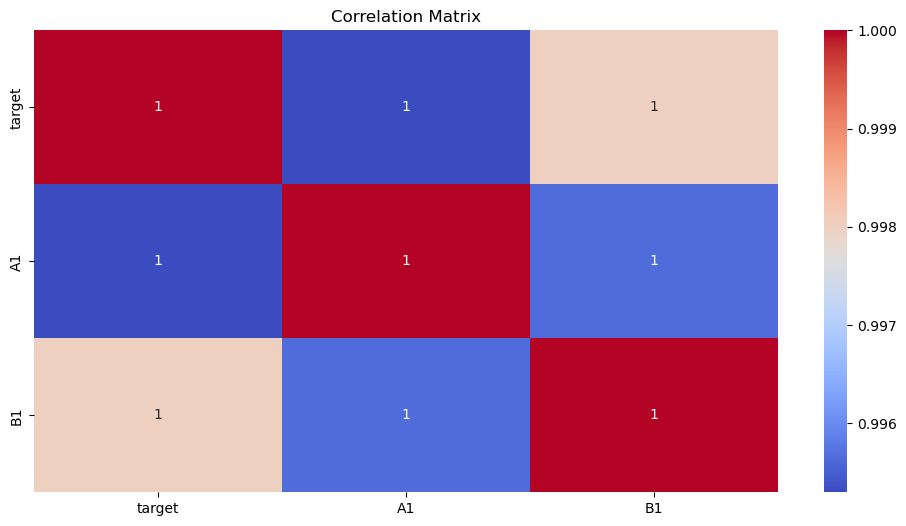

In [11]:
# plot the correlation matrix of the data
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

<Figure size 1200x600 with 0 Axes>

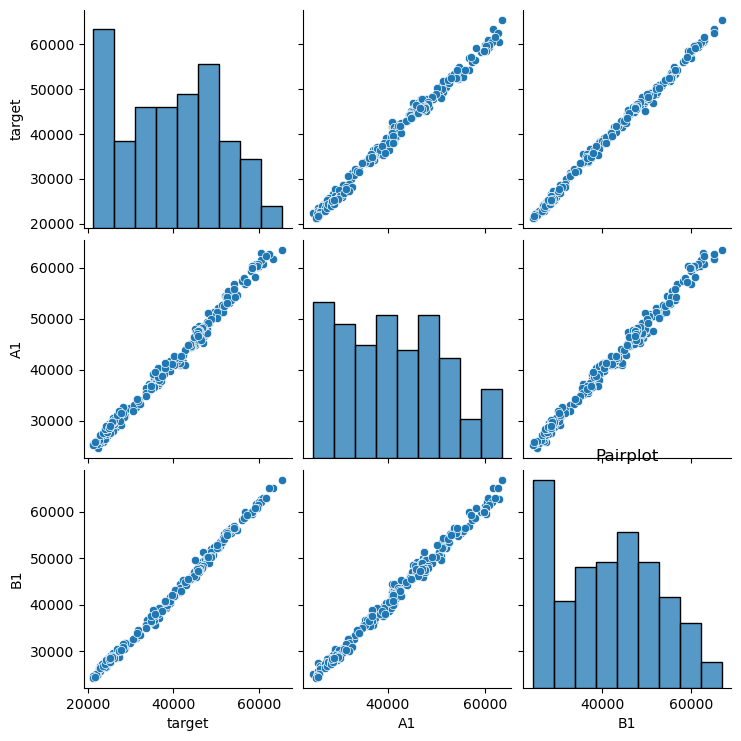

In [12]:
# plot the pairplot of the data
plt.figure(figsize=(12, 6))
sns.pairplot(df)
plt.title("Pairplot")
plt.show()

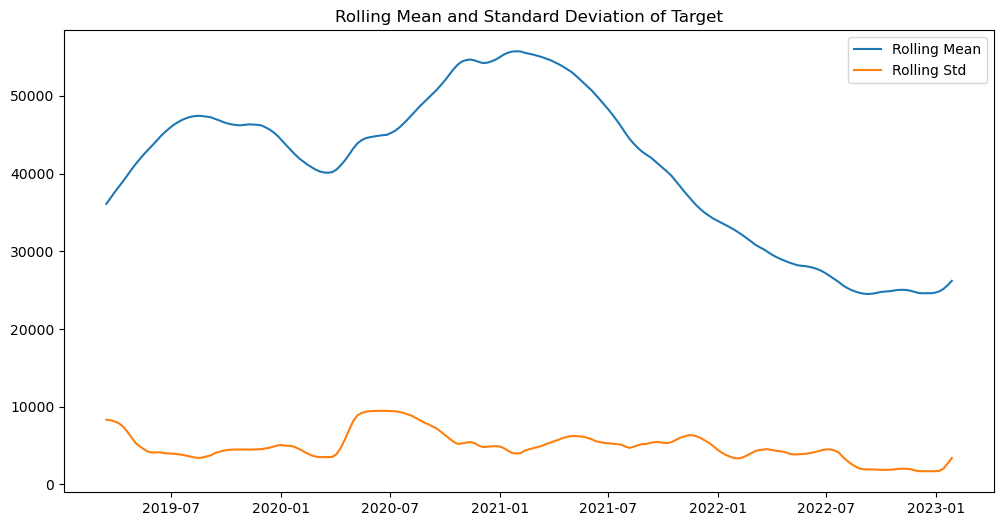

In [13]:
# plot the rolling mean and standard deviation of the target column
plt.figure(figsize=(12, 6))
plt.plot(df["target"].rolling(window=30).mean(), label="Rolling Mean")
plt.plot(df["target"].rolling(window=30).std(), label="Rolling Std")
plt.legend()
plt.title("Rolling Mean and Standard Deviation of Target")
plt.show()

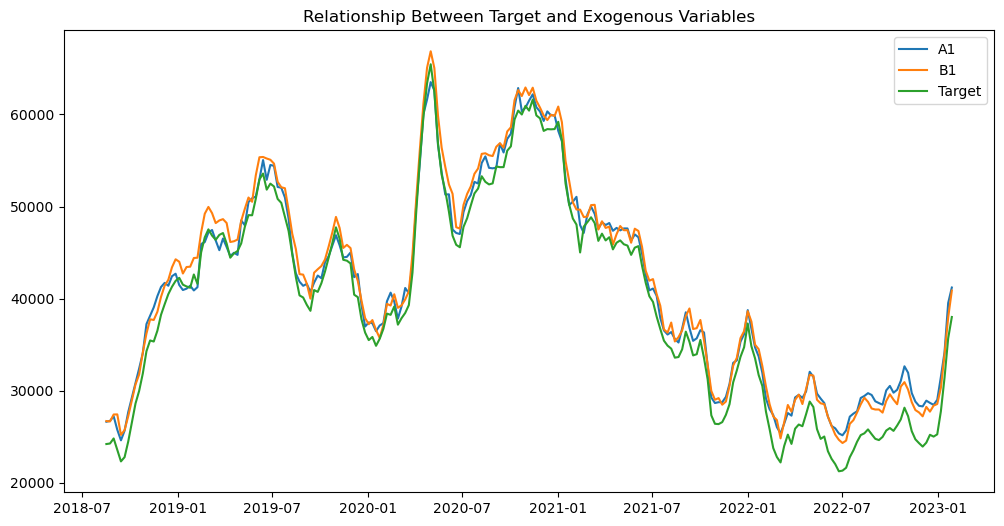

In [14]:
# plot the relationship between Target and the exogenous variables
plt.figure(figsize=(12, 6))
plt.plot(df["A1"], label="A1")
plt.plot(df["B1"], label="B1")
plt.plot(df["target"], label="Target")
plt.legend()
plt.title("Relationship Between Target and Exogenous Variables")
plt.show()

In [15]:
df = df.asfreq(freq="W-FRI")

In [16]:
df.head()

,target,A1,B1
date,,,
2018-08-17,24218.0,26639.85932,26712.400
2018-08-24,24276.0,26732.24945,26670.446
2018-08-31,24825.0,27234.12799,27424.310
2018-09-07,23583.0,25763.61542,27435.742
2018-09-14,22333.0,24621.30913,25207.102


## Preprocessing and Feature Engineering

In [17]:
# find null values in the reindexed data
df[~np.isfinite(df["target"])]

,target,A1,B1
date,,,
2018-10-05,NaN,NaN,NaN


In [18]:
# interpolate to fill missing values
df = df.interpolate()

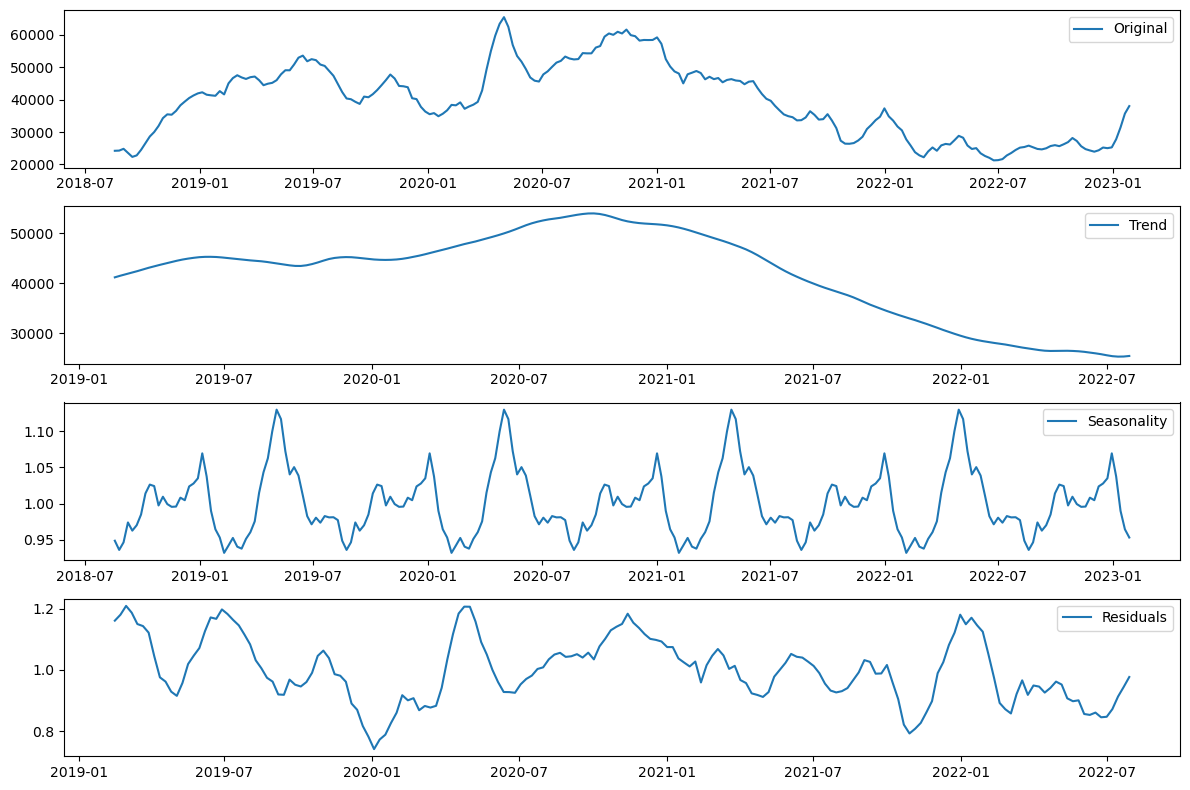

In [19]:
# plot the seasonal decomposition (seasonal decoposition can only be plotted after filling missing values)
result = seasonal_decompose(df['target'], model='multiplicative')

# plot the decomposed time series
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df['target'], label='Original')
plt.legend()
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend()
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonality')
plt.legend()
plt.subplot(414)
plt.plot(result.resid, label='Residuals')
plt.legend()
plt.tight_layout()
plt.show()


WARNING - (py.warnings._showwarnmsg) - /Users/oowola01/opt/anaconda3/envs/mlwork/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(



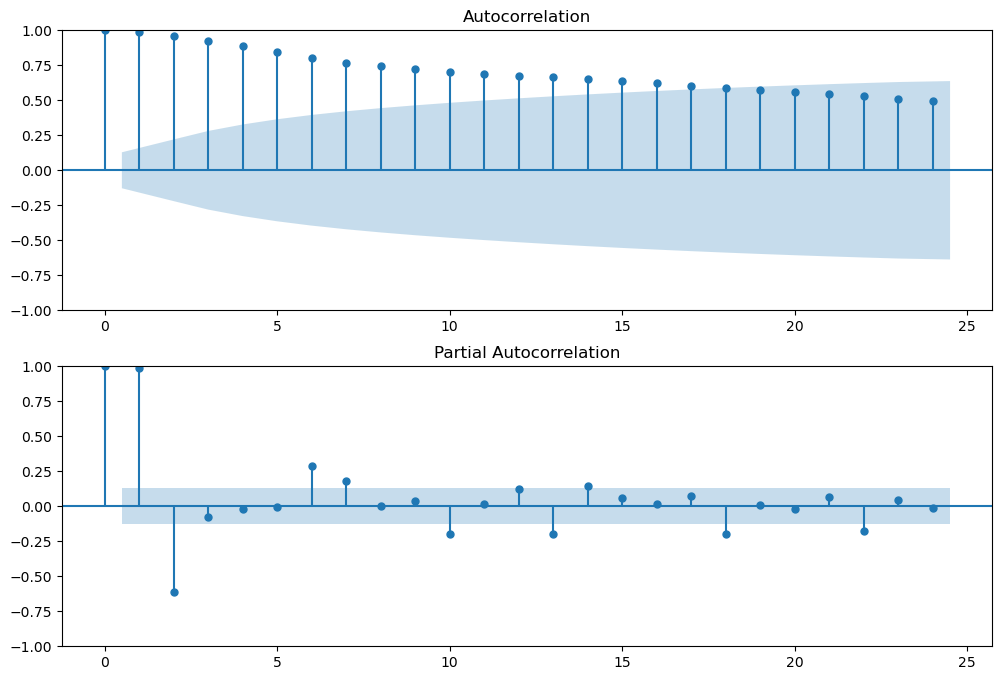

In [20]:
# plot the autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(nrows=2, figsize=(12, 8))
plot_acf(df[["target"]], ax=ax[0])
plot_pacf(df[["target"]], ax=ax[1])
plt.show()

In [21]:
# view data
df.head()

,target,A1,B1
date,,,
2018-08-17,24218.0,26639.85932,26712.400
2018-08-24,24276.0,26732.24945,26670.446
2018-08-31,24825.0,27234.12799,27424.310
2018-09-07,23583.0,25763.61542,27435.742
2018-09-14,22333.0,24621.30913,25207.102


In [22]:
# rename columns for consistency
df = df.reset_index().rename(columns={"date": "ds", "target": "y"})

In [23]:
# Create new features based on the date

# This function extracts the day of the month from a given date string
def is_day(ds):
    """
    :param ds: a date string in the format "yyyy-mm-dd"
    :type ds: str
    :return: the day of the month from the given date string
    :rtype: int
    """
    date = pd.to_datetime(ds)
    return date.day


# This function extracts the quarter of the year from a given date string
def is_quarter(ds):
    """
    :param ds: a date string in the format "yyyy-mm-dd"
    :type ds: str
    :return: the quarter of the year from the given date string
    :rtype: int
    """
    date = pd.to_datetime(ds)
    return date.quarter


# This function extracts the year from a given date string
def is_year(ds):
    """
    :param ds: a date string in the format "yyyy-mm-dd"
    :type ds: str
    :return: the year from the given date string
    :rtype: int
    """
    date = pd.to_datetime(ds)
    return date.year


# This function extracts the month from a given date string
def is_month(ds):
    """
    :param ds: a date string in the format "yyyy-mm-dd"
    :type ds: str
    :return: the month from the given date string
    :rtype: int
    """
    date = pd.to_datetime(ds)
    return date.month


# This code applies each of the date functions to the "ds" column of the dataframe 'df', creating new columns for each feature
df["quarter"] = df["ds"].apply(is_quarter)
df["day"] = df["ds"].apply(is_day)
df["year"] = df["ds"].apply(is_year)
df["month"] = df["ds"].apply(is_month)

## 1b Model

In [24]:
# modeified train test split function with additioonaparameters for columns to drop
def df_train_test_split(df, test_size=0.2, shuffle=False, cols_to_drop=[]):
    df_train, df_test = train_test_split(df, test_size=test_size, shuffle=shuffle)
    df_train = df_train.drop(columns=cols_to_drop)
    df_test = df_test.drop(columns=cols_to_drop)
    return df_train, df_test

### 1b (i) Baseline Linear Prophet Model

In [25]:
# dropping A1 and B1 since their future values are unknown
df_train, df_test = df_train_test_split(
    df, test_size=0.2, shuffle=False, cols_to_drop=["A1", "B1"]
)

In [26]:

class ProphetForecaster:
    """
    A class for creating and evaluating Prophet time series forecasting models.

    Parameters:
    -----------
    known_exog_vars: list
        A list of column names for known exogenous variables that should be used in the model.

    param_grid: dict or None, default=None
        A dictionary of hyperparameters to search over using GridSearchCV. 
        If None, the default hyperparameters of Prophet will be used.
    """

    def __init__(self, known_exog_vars, param_grid=None):
        self.known_exog_vars = known_exog_vars
        self.model = None
        self.param_grid = param_grid
        
    def predict(self, df):
        """
        Predicts future values for the given dataframe using the trained model.

        Parameters:
        -----------
        df: pandas DataFrame
            A dataframe containing the columns to use as inputs for the model.

        Returns:
        --------
        A pandas DataFrame containing the predicted values for each date in the input dataframe.
        """
        return self.model.predict(df)
    
    def evaluate(self, y_true, y_pred):
        """
        Calculates the Mean Absolute Error (MAE) between the true and predicted values.

        Parameters:
        -----------
        y_true: pandas Series
            The true values for the target variable.

        y_pred: pandas Series
            The predicted values for the target variable.

        Returns:
        --------
        The Mean Absolute Error between the true and predicted values.
        """
        return mean_absolute_error(y_true, y_pred)
    
    def make_future_dataframe(self, periods, freq):
        """
        Creates a future dataframe with the specified number of periods and frequency.

        Parameters:
        -----------
        periods: int
            The number of periods to forecast into the future.

        freq: str
            The frequency of the data, in Pandas date offset strings. 
            For example, 'D' for daily data, 'W' for weekly data, 'M' for monthly data, etc.

        Returns:
        --------
        A Pandas DataFrame with a datetime index and the specified number of future periods.
        """
        future = self.model.make_future_dataframe(periods=periods, freq=freq)
        future["quarter"] = future["ds"].apply(is_quarter)
        future["day"] = future["ds"].apply(is_day)
        future["year"] = future["ds"].apply(is_year)
        future["month"] = future["ds"].apply(is_month)
        return future
    
    def fit(self, df_train, model):
        """
        Fits the model to the training data using the known exogenous variables.

        Parameters:
        -----------
        df_train: pandas DataFrame
            A dataframe containing the columns to use as inputs for the model and the target variable.

        model: Prophet
            An instance of the Prophet class with hyperparameters set. 
            This model will be trained on the input training data.
        """
        self.model = model
        for i in self.known_exog_vars:
            self.model.add_regressor(name=i)
        self.model.fit(df_train)
    
    def plot_forecast(self, forecast):
        """
        Plots the forecasted values.

        Parameters:
        -----------
        forecast: pandas DataFrame
            A dataframe containing the forecasted values.
        """
        self.model.plot(forecast);
    
    def plot_component(self, forecast):
        """
        Plots the trend, seasonality, and holiday components of the forecast.

        Parameters:
        -----------
        forecast: pandas DataFrame
            A dataframe containing the forecasted values
        """
        self.model.plot_components(forecast);


In [27]:
# create an instance of the ProphetModel class
model = ProphetForecaster(
    known_exog_vars=["day", "month", "year", "quarter"],
)

# train the model on the training set
model.fit(df_train,  model=Prophet())

# make predictions on the testing set
test_forecast = model.predict(df_test)

# evaluate the model on the testing set using MAE
mae_pretuned_prp = model.evaluate(df_test["y"], test_forecast["yhat"])

# fit the model on the entire data
model.fit(df, model=Prophet())

# make predictions on future data
future = model.make_future_dataframe(periods=3, freq="W-FRI")
forecast = model.predict(future)


23:22:18 - cmdstanpy - INFO - Chain [1] start processing
23:22:18 - cmdstanpy - INFO - Chain [1] done processing
23:22:18 - cmdstanpy - INFO - Chain [1] start processing
23:22:18 - cmdstanpy - INFO - Chain [1] done processing


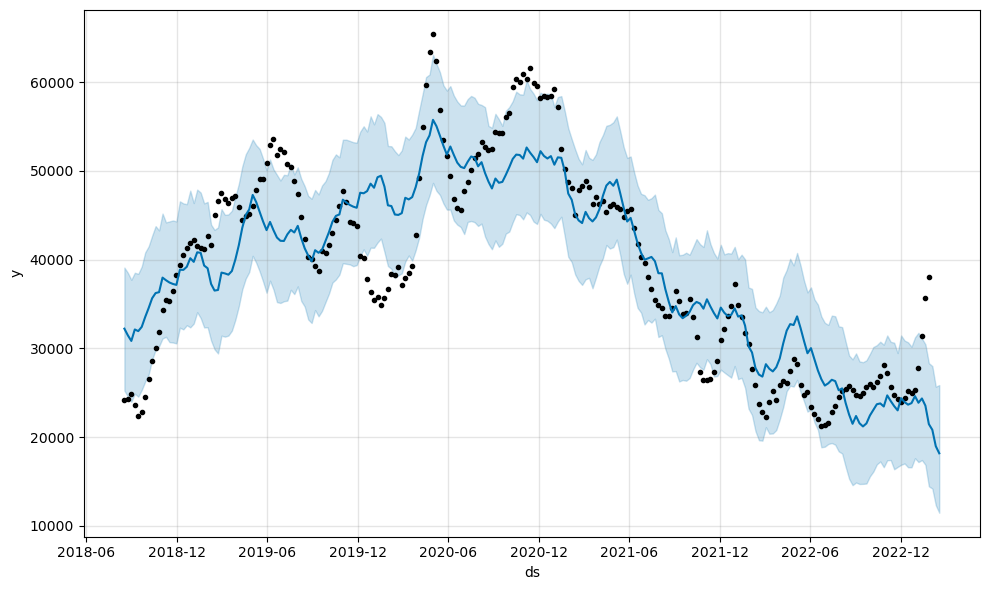

In [28]:
# plot the forecast
model.plot_forecast(forecast)

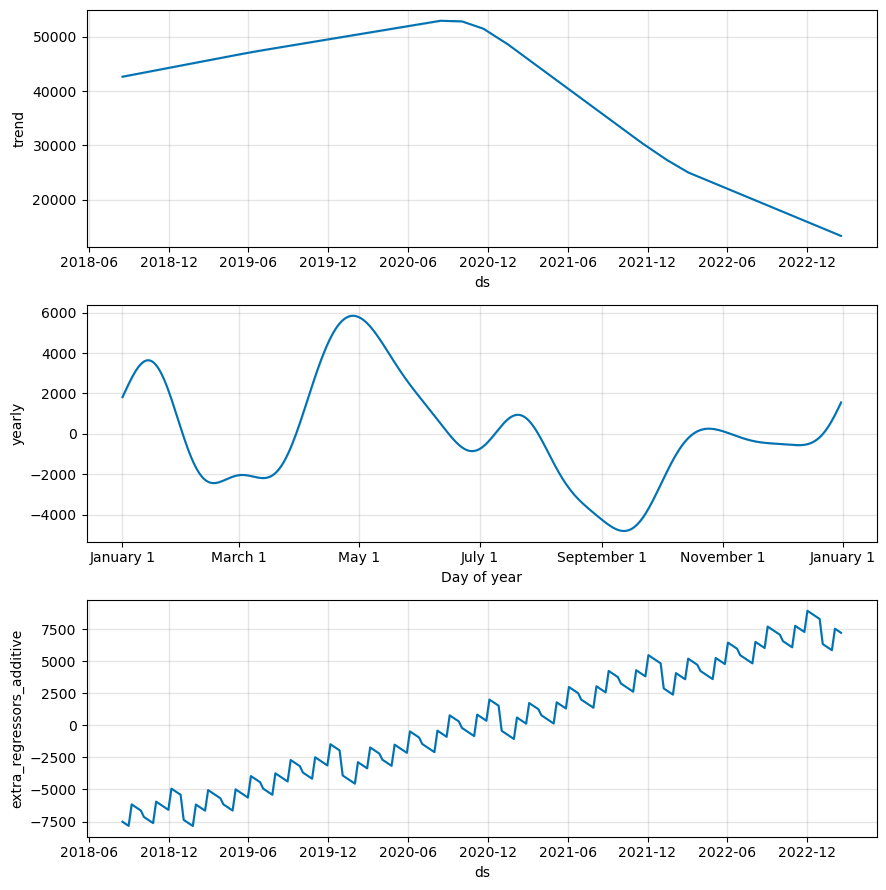

In [29]:
# plot the forecast components
model.plot_component(forecast)

In [30]:
test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,day,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-03-11,15385.281186,18483.153470,31015.746553,15385.281186,15385.281186,9716.738288,9716.738288,9716.738288,206.772715,...,13192.777374,13192.777374,13192.777374,-1912.007964,-1912.007964,-1912.007964,0.0,0.0,0.0,25102.019473
1,2022-03-18,14860.036929,17743.264830,30642.702058,14856.087980,14861.555290,9772.515787,9772.515787,9772.515787,-92.026480,...,13192.777374,13192.777374,13192.777374,-1557.431270,-1557.431270,-1557.431270,0.0,0.0,0.0,24632.552716
2,2022-03-25,14334.792673,18064.483942,31748.538032,14316.218918,14348.174408,10675.469978,10675.469978,10675.469978,-390.825675,...,13192.777374,13192.777374,13192.777374,-355.677883,-355.677883,-355.677883,0.0,0.0,0.0,25010.262651
3,2022-04-01,13809.548416,19721.397516,32858.799979,13768.679415,13836.772330,12467.619696,12467.619696,12467.619696,633.628708,...,13192.777374,13192.777374,13192.777374,1628.877547,1628.877547,1628.877547,0.0,0.0,0.0,26277.168113
4,2022-04-08,13284.304160,21186.640590,34671.409964,13217.931901,13330.751086,14520.168843,14520.168843,14520.168843,334.829513,...,13192.777374,13192.777374,13192.777374,3980.225889,3980.225889,3980.225889,0.0,0.0,0.0,27804.473003


In [31]:
# view predictions
forecast.tail(4)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,day,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
232,2023-01-27,14080.553395,14451.803164,28338.511269,14080.553395,14080.553395,7385.650123,7385.650123,7385.650123,-255.093409,...,9189.953109,9189.953109,9189.953109,1508.941555,1508.941555,1508.941555,0.0,0.0,0.0,21466.203518
233,2023-02-03,13847.285198,14198.121597,28007.132097,13847.285198,13847.285198,6973.523474,6973.523474,6973.523474,292.710870,...,9189.953109,9189.953109,9189.953109,-579.015858,-579.015858,-579.015858,0.0,0.0,0.0,20820.808672
234,2023-02-10,13614.017000,12323.170407,25682.935083,13611.583050,13614.736364,5359.976941,5359.976941,5359.976941,132.934622,...,9189.953109,9189.953109,9189.953109,-2032.786143,-2032.786143,-2032.786143,0.0,0.0,0.0,18973.993941
235,2023-02-17,13380.748803,11469.285010,25867.350087,13368.299390,13390.424063,4793.128211,4793.128211,4793.128211,-26.841626,...,9189.953109,9189.953109,9189.953109,-2439.858625,-2439.858625,-2439.858625,0.0,0.0,0.0,18173.877014


### 1b (i) Hyperparameter Tuned Linear Prophet Model

In [32]:
class ProphetGridSearch:
    def __init__(self, known_exog_vars: List[str], param_grid: Dict[str, List]):
        """
        Initialize ProphetGridSearch class with the given parameters.

        :param known_exog_vars: List of known exogenous variables to use in the Prophet model.
        :param param_grid: Dictionary of hyperparameters and their possible values to be tuned.
        """
        self.best_model = None
        self.best_mae = float("inf")
        self.best_param = None
        self.known_exog_vars = known_exog_vars
        self.param_grid = param_grid

    def gridsearch(self, df_train: pd.DataFrame, df_test: pd.DataFrame):
        """
        Grid search over all combinations of hyperparameters and select the best Prophet model based on MAE.

        :param df_train: Training dataframe.
        :param df_test: Testing dataframe.
        """
        # Loop over all combinations of hyperparameters
        for params in ParameterGrid(self.param_grid):

            # Initialize a ProphetForecaster object
            m = ProphetForecaster(known_exog_vars=self.known_exog_vars)

            # Train the model on the training set
            m.fit(df_train, model=Prophet(**params))

            # Make predictions on the testing set
            test_forecast = m.predict(df_test)

            # Evaluate the model on the testing set using MAE
            mae = m.evaluate(df_test["y"], test_forecast["yhat"])

            # Update the best model if the current model has a lower MAE
            if mae < self.best_mae:
                self.best_mae = mae
                self.best_model = m
                self.best_param = params

        print("Best Hyperparameters:", self.best_param)
        print("Best MAE:", self.best_mae)

In [33]:
# Define the parameter grid to search over
param_grid = {
    "seasonality_mode": ["multiplicative", "additive"],
    "changepoint_prior_scale": [0.001, 0.01, 0.1, 0.5, 1],
    "seasonality_prior_scale": [0.01, 0.1, 1, 10],
    "changepoint_range": [0.9, 0.95],
    "yearly_seasonality": [True,],
}

In [34]:
# Create an instance of the ProphetGridSearch class with the specified known exogenous variables and parameter grid
grid_cv = ProphetGridSearch(
    known_exog_vars=["day", "month", "year", "quarter"], param_grid=param_grid
)

# Perform a grid search over the hyperparameter space using the training and testing sets
grid_cv.gridsearch(df_train, df_test)

# Get the best hyperparameters and corresponding MAE from the grid search
tuned_prp_best_param = grid_cv.best_param
best_mae_tuned_prp = grid_cv.best_mae

23:22:19 - cmdstanpy - INFO - Chain [1] start processing
23:22:19 - cmdstanpy - INFO - Chain [1] done processing
23:22:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
23:22:19 - cmdstanpy - INFO - Chain [1] start processing
23:22:19 - cmdstanpy - INFO - Chain [1] done processing
23:22:19 - cmdstanpy - INFO - Chain [1] start processing
23:22:19 - cmdstanpy - INFO - Chain [1] done processing
23:22:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
23:22:19 - cmdstanpy - INFO - Chain [1] start processing
23:22:20 - cmdstanpy - INFO - Chain [1] done processing
23:22:20 - cmdstanpy - INFO - Chain [1] start processing
23:22:20 - cmdstanpy - INFO - Chain [1] done processing
23:22:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormall

Best Hyperparameters: {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.9, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'yearly_seasonality': True}
Best MAE: 2659.5963665322474


In [35]:
# create an instance of the ProphetModel class
model = ProphetForecaster(
    known_exog_vars=["day", "month", "year", "quarter"]
)

# fit the model on the entire data
model.fit(df, model=Prophet(**tuned_prp_best_param))

# make predictions on future data
future = model.make_future_dataframe(periods=3, freq="W-FRI")
forecast = model.predict(future)


23:22:39 - cmdstanpy - INFO - Chain [1] start processing
23:22:39 - cmdstanpy - INFO - Chain [1] done processing


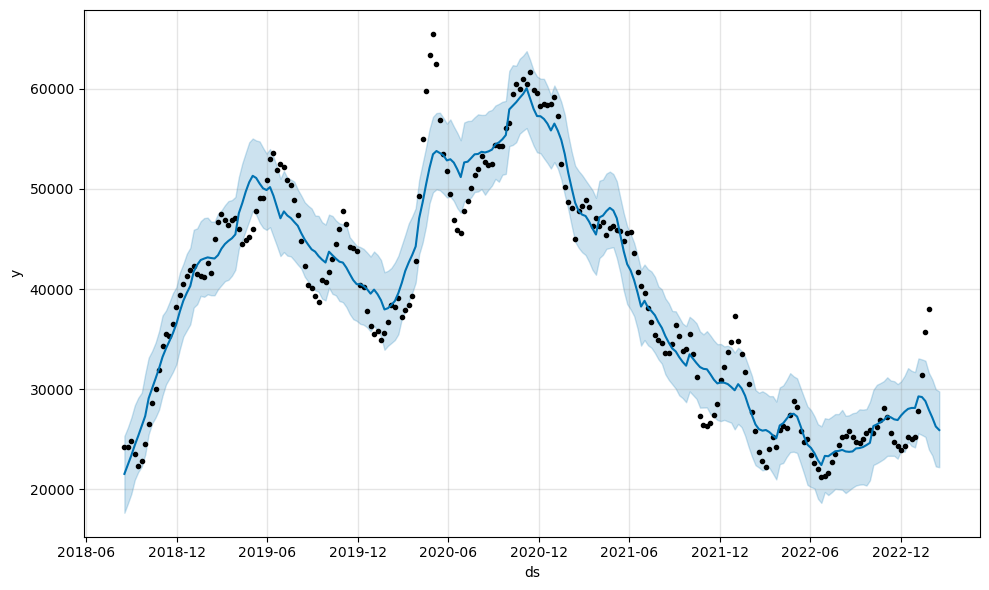

In [36]:
# plot the forecast
model.plot_forecast(forecast)

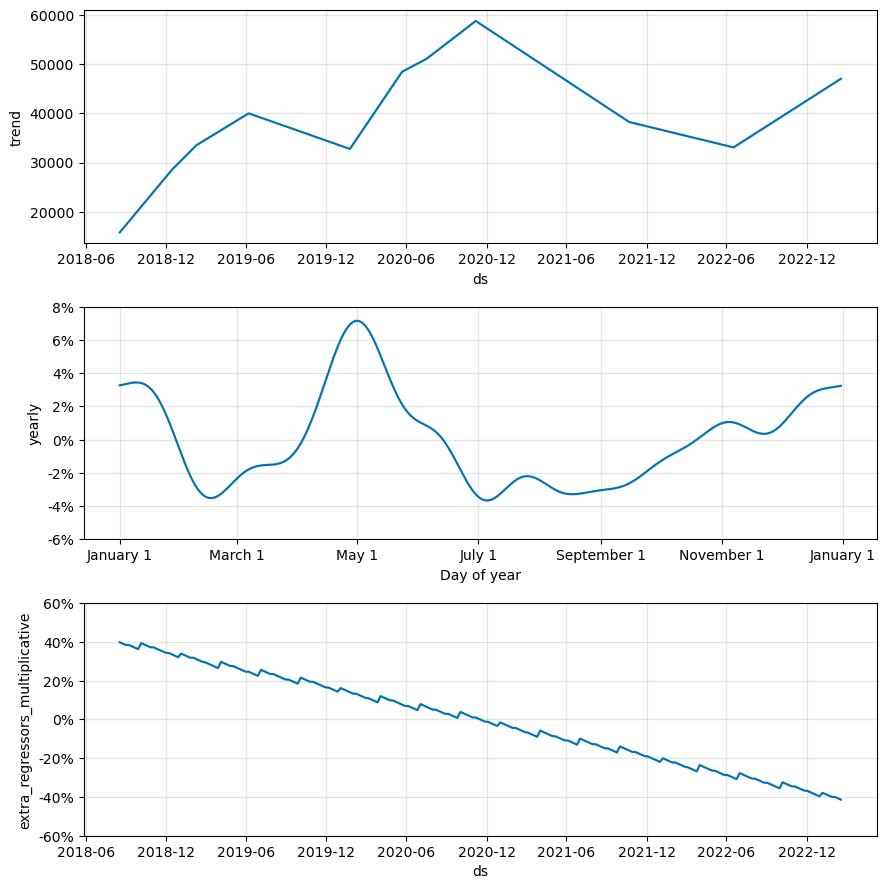

In [37]:
# plot forecast component
model.plot_component(forecast)

### 1b (i) Pretuned Non-Linear Neural Prophet Model

In [38]:
# leaving A1 and B1 since NP model can handle cases where future values are unknown
df_train, df_test = df_train_test_split(
    df, test_size=0.2, shuffle=False, cols_to_drop=[]
)

In [39]:
class NeuralProphetForecaster:
    def __init__(self, known_exog_vars, param_grid=None):
        """
        Initialize the NeuralProphetForecaster.

        Parameters:
        known_exog_vars (list): list of column names of known exogenous variables
        param_grid (dict): dictionary of hyperparameters to be tuned (default=None)
        """
        self.known_exog_vars = known_exog_vars
        self.model = None
        self.param_grid = param_grid
        self.metrics = None
        
    def predict(self, df):
        """
        Generate predictions for the input dataframe.

        Parameters:
        df (pandas.DataFrame): dataframe containing time series data to make predictions for

        Returns:
        pandas.DataFrame: dataframe containing predictions
        """
        return self.model.predict(df)
    
    def evaluate(self):
        """
        Evaluate the model's performance on the validation set.

        Returns:
        float: minimum mean absolute error (MAE) on the validation set
        """
        return self.metrics["MAE_val"].min()
    
    def make_future_dataframe(self, df):
        """
        Create a future dataframe to make predictions.

        Parameters:
        df (pandas.DataFrame): dataframe containing time series data

        Returns:
        pandas.DataFrame: future dataframe
        """
        future = self.model.make_future_dataframe(df, n_historic_predictions=len(df))
        future["quarter"] = future["ds"].apply(is_quarter)
        future["day"] = future["ds"].apply(is_day)
        future["year"] = future["ds"].apply(is_year)
        future["month"] = future["ds"].apply(is_month)
        return future
    
    def fit(self, df_train, df_test, model):
        """
        Fit the NeuralProphet model.

        Parameters:
        df_train (pandas.DataFrame): dataframe containing time series training data
        df_test (pandas.DataFrame): dataframe containing time series validation data
        model (NeuralProphet): NeuralProphet model object
        """
        self.model = model
        self.model.add_lagged_regressor(names=self.known_exog_vars)
        self.metrics = self.model.fit(df=df_train, freq="W-FRI", validation_df=df_test, progress="plot")
        
    def plot_forecast(self, forecast):
        """
        Plot the forecast generated by the model.

        Parameters:
        forecast (pandas.DataFrame): dataframe containing forecast data
        """
        self.model.plot(forecast)
    
    def plot_component(self):
        """
        Plot the trained model's parameter components.
        """
        return self.model.plot_parameters()


In [40]:
# Define the exogenous variables
exog_vars = ["A1", "B1", "day", "month", "year", "quarter"]

# create an instance of the NeuralProphetModel class
model = NeuralProphetForecaster(
    known_exog_vars=exog_vars,
)

# train the model on the training set
metrics = model.fit(df_train, df_test,  model=NeuralProphet(
    n_forecasts=3,
))


# evaluate the model on the testing set using MAE
mae_pretuned_np = model.evaluate()


# make predictions on future data
future = model.make_future_dataframe(df)
forecast = model.predict(future)


INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency W-FRI corresponds to 99.462% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-FRI
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 382


  0%|          | 0/111 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.13E-01, min: 2.91E-01


  0%|          | 0/111 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.13E-01, min: 2.91E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.09E-01
WARNING - (NP.forecaster._train) - To plot live loss, please install neuralprophet[live].Using pip: 'pip install neuralprophet[live]'Or install the missing package manually: 'pip install livelossplot'
Traceback (most recent call last):
  File "/Users/oowola01/opt/anaconda3/envs/mlwork/lib/python3.9/site-packages/neuralprophet/forecaster.py", line 2546, in _train
    from livelossplot import PlotLosses
ModuleNotFoundError: No module named 'livelossplot'
Epoch[382/382]: 100%|██████████| 382/382 [00:09<00:00, 41.72it/s, SmoothL1Loss=0.00214, MAE=1.81e+3, RMSE=2.42e+3, Loss=0.00157, RegLoss=0, MAE_val=2.81e+3, RMSE_val=3.96e+3, SmoothL1Loss_val=0.00558]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-FRI corresponds to 99.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency i

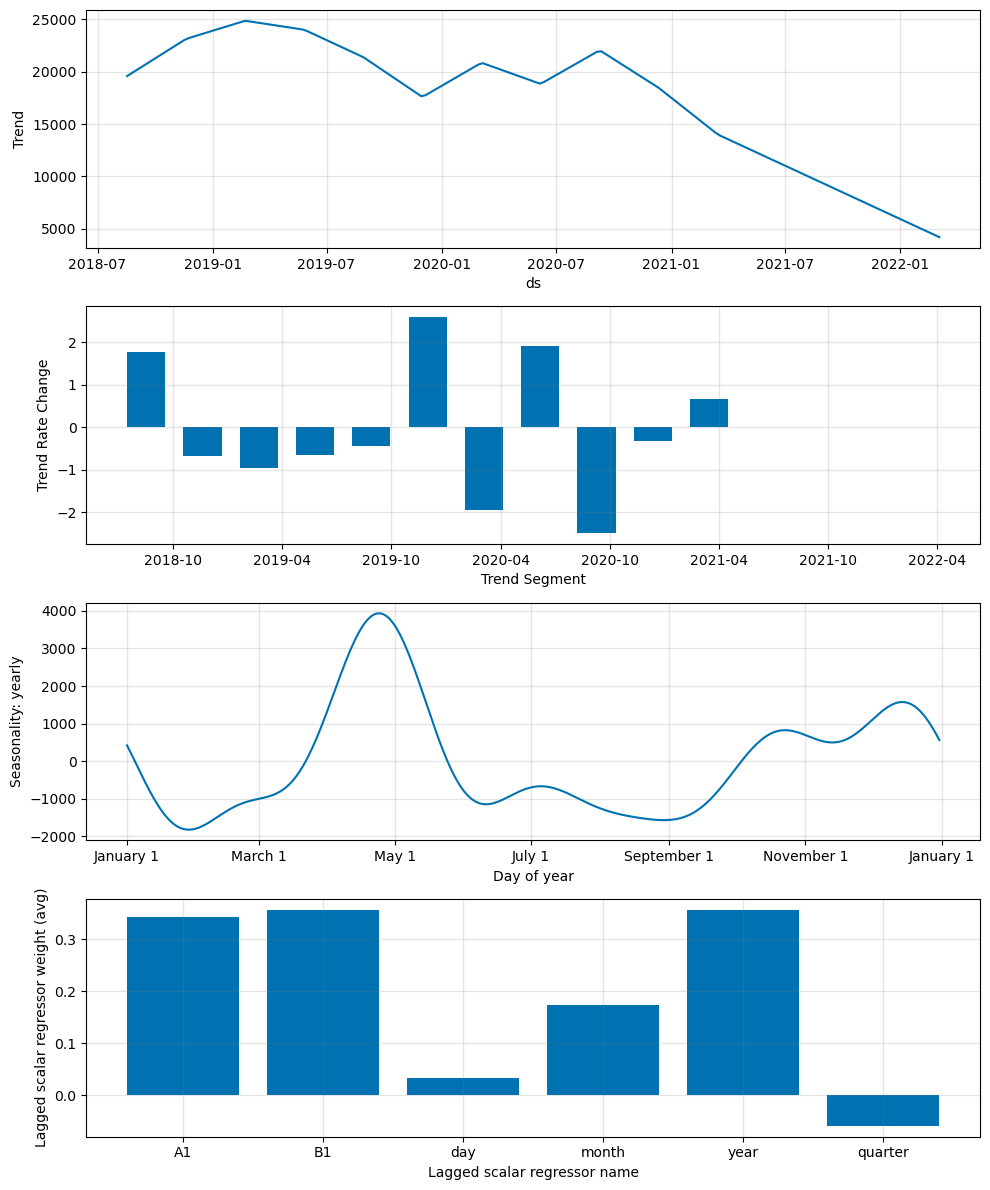

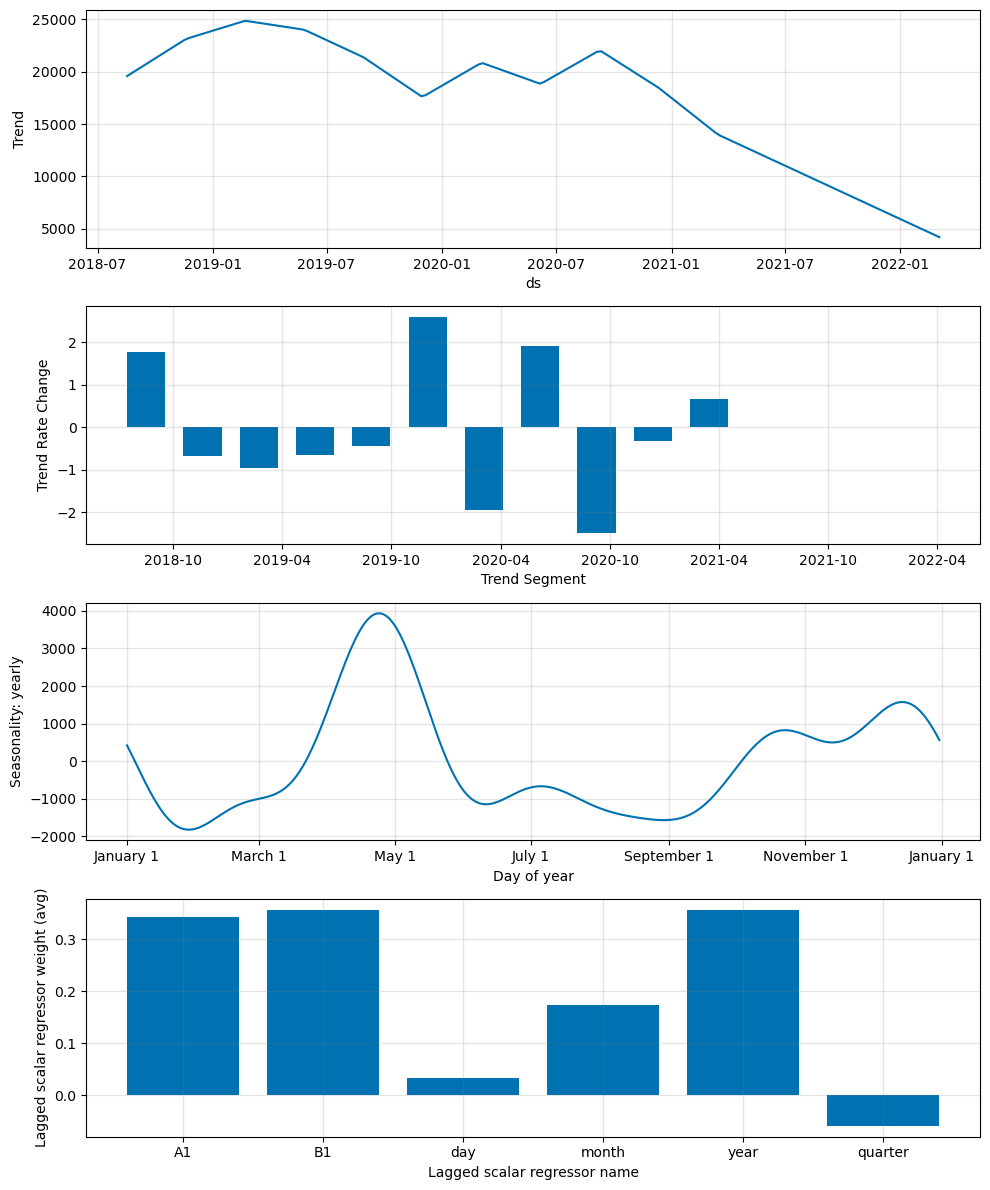

In [41]:
model.plot_component()

### 1b (ii) Hyperparameter Tuned Neural Prophet Model

In [42]:
class NeuralProphetGridSearch:
    def __init__(self, known_exog_vars, param_grid):
        """
        Constructor for NeuralProphetGridSearch class.

        Parameters:
            known_exog_vars (list of str): List of names of known exogenous variables.
            param_grid (dict): Dictionary containing hyperparameters to search over.
        """
        self.best_model = None
        self.best_mae = float("inf")
        self.best_param = None
        self.known_exog_vars = known_exog_vars
        self.param_grid = param_grid

    def gridsearch(self, df_train, df_test):
        """
        Perform grid search over hyperparameters to find the best NeuralProphet model.

        Parameters:
            df_train (pandas DataFrame): Training data.
            df_test (pandas DataFrame): Testing data.
        """
        # Loop over all combinations of hyperparameters
        for params in ParameterGrid(self.param_grid):

            # create an instance of the NeuralProphetModel class
            model = NeuralProphetForecaster(known_exog_vars=self.known_exog_vars)

            # train the model on the training set
            metrics = model.fit(df_train, df_test, model=NeuralProphet(**params))

            # evaluate the model on the testing set using MAE
            mae = model.evaluate()

            # Update the best model if the current model has a lower MAE
            if mae < self.best_mae:
                self.best_mae = mae
                self.best_model = model
                self.best_param = params
        # Print the best hyperparameters and MAE
        print("Best Hyperparameters:", self.best_param)
        print("Best MAE:", self.best_mae)


In [43]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    "num_hidden_layers": [1, 2],
    "d_hidden": [4, 8],
    "learning_rate": [0.01, 0.1],
    "yearly_seasonality": [True],
    "n_lags": [3],
    "changepoints_range": [0.95],
    "n_lags": [3],
    "n_forecasts":[3]
}


In [44]:
grid_cv = NeuralProphetGridSearch(
    known_exog_vars=["A1", "B1", "day", "month", "year", "quarter"],
    param_grid=param_grid,
)
grid_cv.gridsearch(df_train, df_test)
tuned_np_best_param = grid_cv.best_param
best_mae_tuned_np = grid_cv.best_mae
best_model_tuned_np = grid_cv.best_model

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (3)
INFO - (NP.df_utils._infer_frequency) - Major frequency W-FRI corresponds to 99.462% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-FRI
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 384
WARNING - (NP.forecaster._train) - To plot live loss, please install neuralprophet[live].Using pip: 'pip install neuralprophet[live]'Or install the mi

Best Hyperparameters: {'changepoints_range': 0.95, 'd_hidden': 4, 'learning_rate': 0.01, 'n_forecasts': 3, 'n_lags': 3, 'num_hidden_layers': 2, 'yearly_seasonality': True}
Best MAE: 1928.903076171875


In [45]:
# Define the exogenous variables
exog_vars = ["A1", "B1", "day", "month", "year", "quarter"]

# create an instance of the NeuralProphetModel class
model = NeuralProphetForecaster(
    known_exog_vars=exog_vars,
)

# train the model on the training set
metrics = model.fit(df_train, df_test,  model=NeuralProphet(**tuned_np_best_param
))

# evaluate the model on the testing set using MAE
mae_tuned_np = model.evaluate()


# make predictions on future data
future = model.make_future_dataframe(df)
forecast = model.predict(future)


INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (3)
INFO - (NP.df_utils._infer_frequency) - Major frequency W-FRI corresponds to 99.462% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-FRI
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 384
WARNING - (NP.forecaster._train) - To plot live loss, please install neuralprophet[live].Using pip: 'pip install neuralprophet[live]'Or install the mi

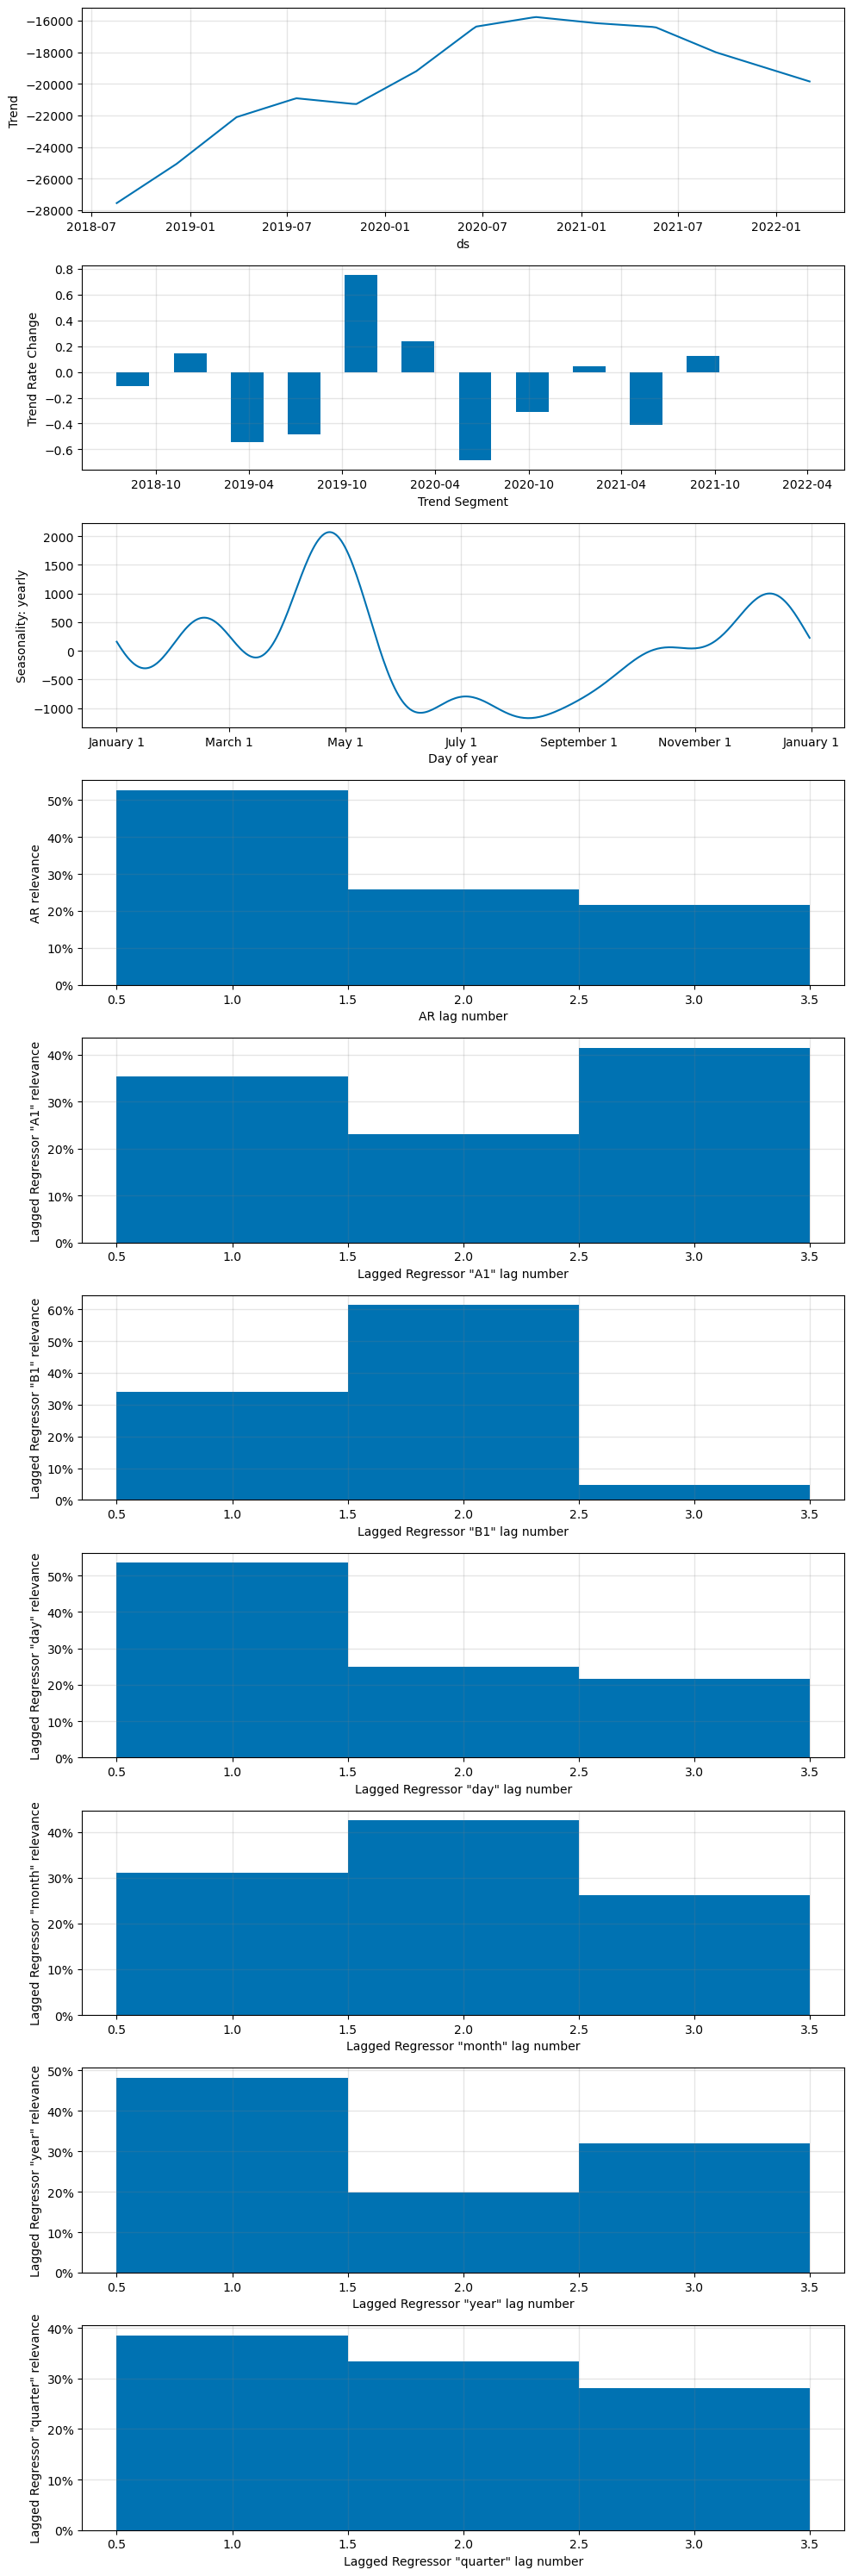

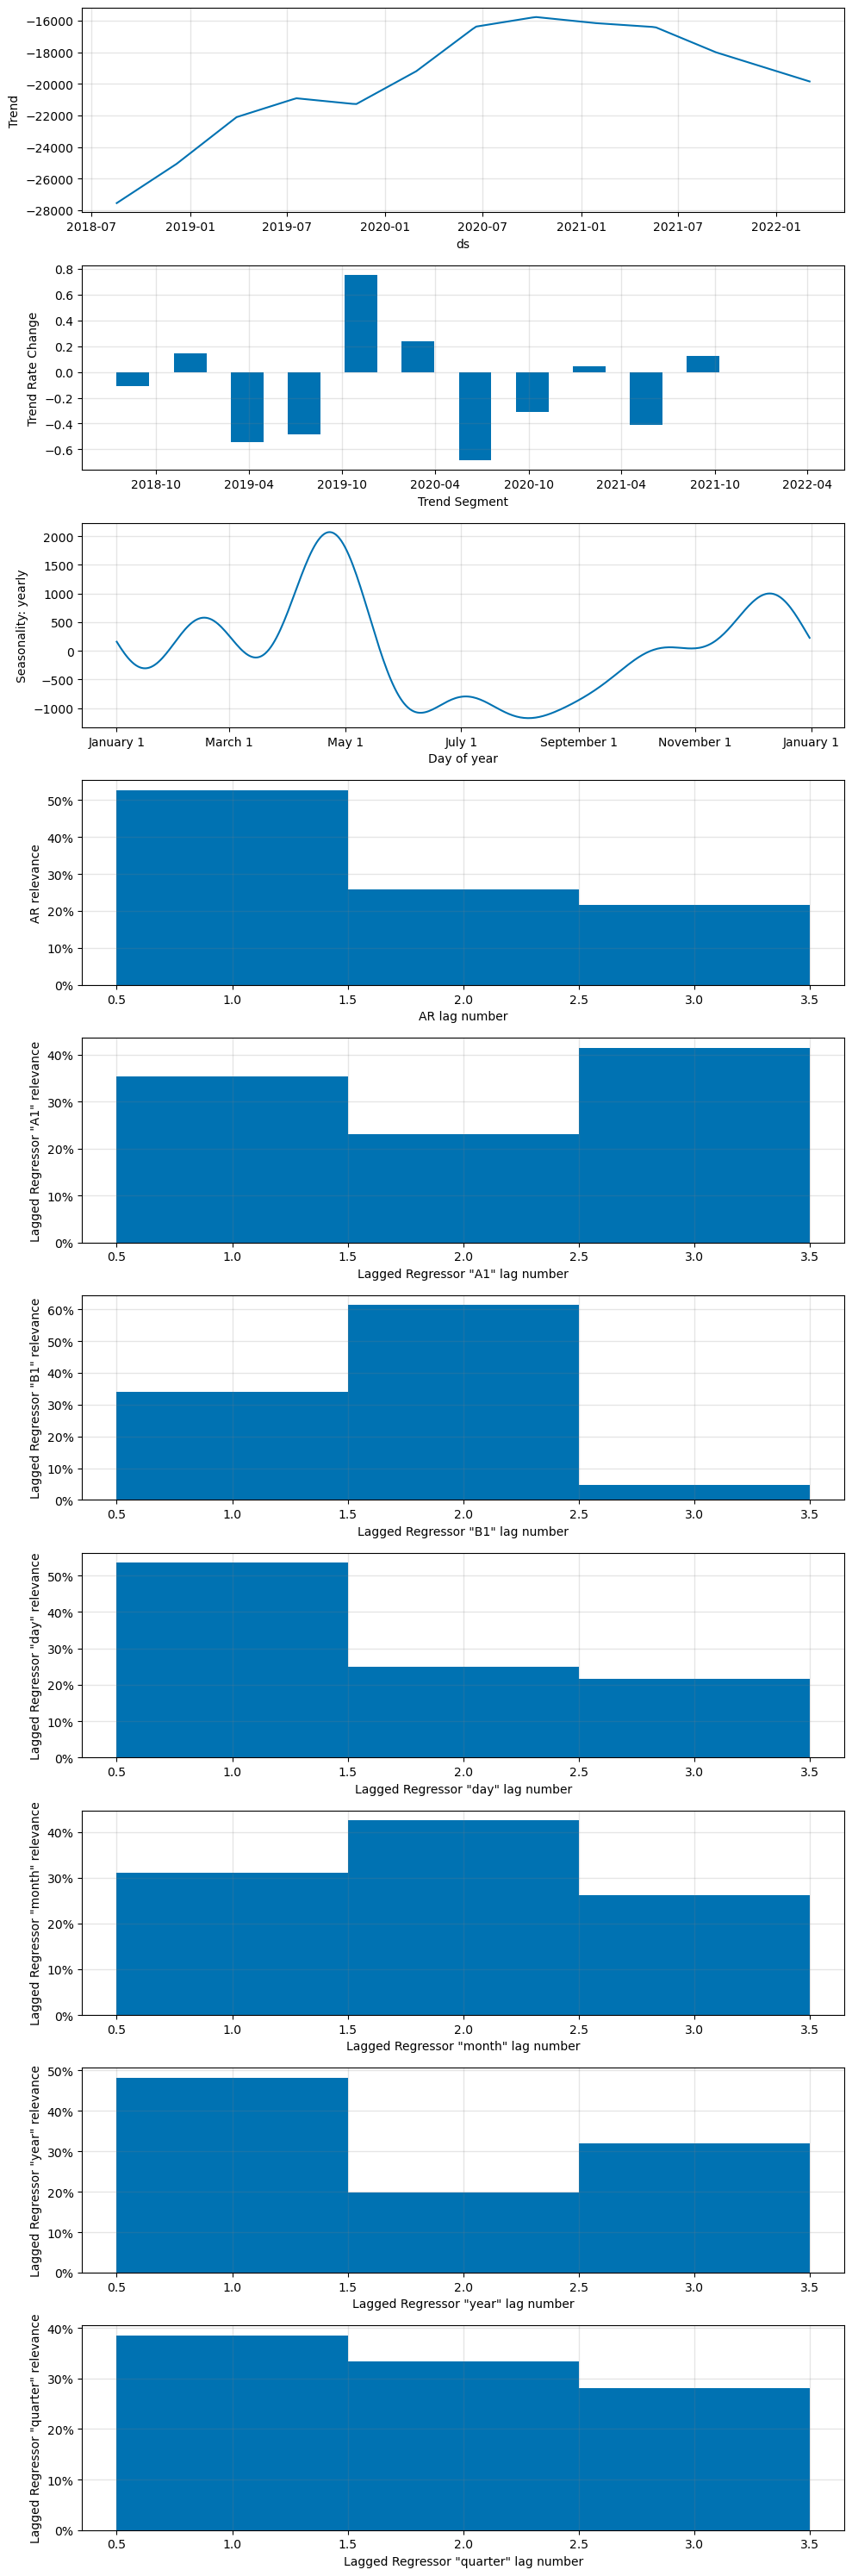

In [46]:
# plot component
model.plot_component()

In [47]:
# view last 5 forecast
forecast.tail(5)

,ds,y,residual1,yhat1,residual2,yhat2,residual3,yhat3,ar1,ar2,...,lagged_regressor_month2,lagged_regressor_month3,lagged_regressor_year1,lagged_regressor_year2,lagged_regressor_year3,lagged_regressor_quarter1,lagged_regressor_quarter2,lagged_regressor_quarter3,trend,season_yearly
231,2023-01-20,35694.0,-9724.818359,25969.181641,-14494.871094,21199.128906,-16381.013672,19312.986328,22082.972656,-49864.433594,...,23486.277344,-21033.035156,23953.34375,30920.566406,18820.773438,-5037.730469,23064.236328,-155.64473,-23245.203125,-275.501648
232,2023-01-27,38009.0,-9014.783203,28994.216797,-8751.828125,29257.171875,-16362.244141,21646.755859,24312.740234,-47920.847656,...,19869.908203,-22505.542969,16143.845703,44259.328125,9474.71582,56.689774,14048.615234,8306.913086,-23318.960938,-69.361336
233,2023-02-03,NaN,NaN,30837.261719,NaN,34380.324219,NaN,27875.818359,24026.302734,-49411.035156,...,8852.429688,-36065.929688,16143.845703,51345.796875,16054.349609,56.689774,18223.619141,16359.298828,-23392.71875,234.198135
234,2023-02-10,NaN,NaN,None,NaN,34203.898438,NaN,29962.359375,None,-51454.691406,...,8852.429688,-21935.804688,None,51345.796875,15928.481445,None,18223.619141,2588.529297,-23466.476562,489.811279
235,2023-02-17,NaN,NaN,None,NaN,None,NaN,30750.316406,None,None,...,None,-21935.804688,None,None,15928.481445,None,None,2588.529297,-23540.230469,577.372864


### 1b (ii) Comparison

In [48]:
##bar plot of MAEs

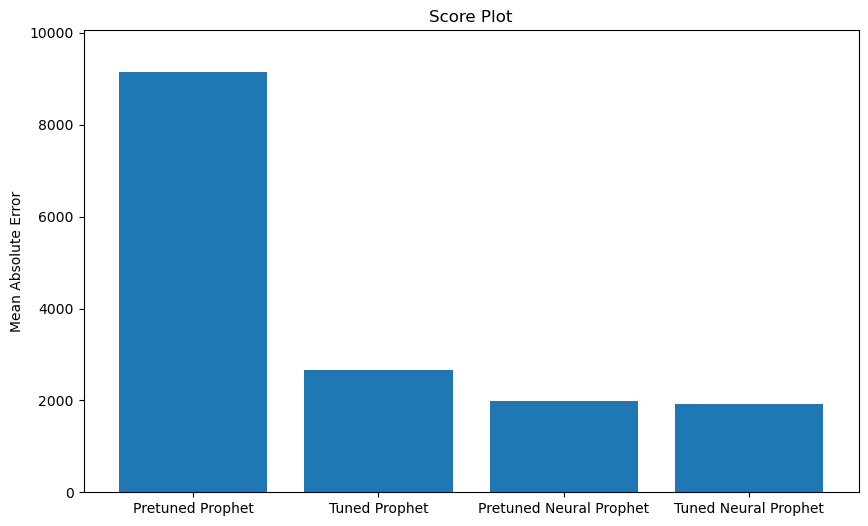

In [49]:
def score_plot():
    """Visualizing the training + validation sets"""
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)

    scores = {
        "Pretuned Prophet": mae_pretuned_prp,
        "Tuned Prophet": best_mae_tuned_prp,
        "Pretuned Neural Prophet": mae_pretuned_np,
        "Tuned Neural Prophet": best_mae_tuned_np,
    }

    ax.set_title("Score Plot")
    ax.bar(scores.keys(), scores.values())
    ax.margins(y=0.1)
    plt.ylabel("Mean Absolute Error")
    plt.show()


score_plot()

## 1c. Discussion of Metric Choice

In summary, MAE is a good choice for this time series forecasting work because it is intuitive, robust to outliers, scale-independent. It measures the average absolute difference between the predicted and actual values. There are several reasons why MAE is a good choice for this time series forecasting problem:

1. MAE is intuitive and easy to understand: The MAE is simply the average of the absolute differences between the predicted and actual values. This makes it easy to interpret and communicate the accuracy of the model to stakeholders.

2. MAE is robust to outliers: MAE is less sensitive to outliers than other metrics such as mean squared error (MSE), which squares the errors before averaging them. This means that a few large errors won't have as much impact on the overall metric as they would with MSE.

3. MAE is scale-independent: MAE is measured in the same units as the forecast variable, making it easy to compare across different time series or forecasting models. This is not the case for other metrics such as percentage errors, which are dependent on the scale of the data.

## Bonus: Pros and Cons of Variable Length Horizon

Pros:
Flexibility - A variable output length model provides more flexibility in terms of the forecasting horizon. This means that the model can be used to generate forecasts for a range of time horizons, without needing to retrain the model or change any hyperparameters.

Cons:
Complexity -  A model with a variable output length can be more complex than a model with a fixed output length. This is because the model needs to be able to generate forecasts for different lengths of time horizons, which can make the model architecture more complicated and increase the time complexity.


## Summary

This time series forecasting work evaluated two classes of models: the linear model (Prophet) and the non-linear model (Neural Prophet based on a deep learning architecture). Both tuned and pre-tuned variants of each model were examined, resulting in four models for forecasting the target variable over the next three horizons. The results indicated that the Tuned Neural Prophet model produced the lowest Mean Square Error, suggesting that it better captured the non-linear trends in the data.

## Future Work

Despite the promising results obtained from this work, there are still opportunities for future work. One direction for future work would be to explore the use of other time series regression models like LSTM, GRU, and ConvLSTM, which are known for their ability to capture long-term dependencies and nonlinear patterns in time series data. Additionally, incorporating more exogenous variables or alternative feature engineering techniques, such as time-series cross-validation, may improve the model's performance. Finally, testing the models on larger and more diverse datasets with varying time-series characteristics could also provide more insights into the robustness and generalizability of the models developed in this work.